In [45]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

from collections import defaultdict
import torch
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt

In [46]:

seva_data_path = "../toy_data/TOY_seva_modified20apr.xlsx"
candidate_info_df = pd.read_excel(seva_data_path)

skills_jobs_df = pd.DataFrame()
skills_jobs_df["SP ID"] = candidate_info_df["SP ID"]
skills_jobs_df['Skills Jobs'] = candidate_info_df['Skills'].fillna(' ')
# skills_jobs_df['Skills Jobs'] = candidate_info_df['Work Experience/Designation'].fillna(' ') + " " + candidate_info_df['Any Additional Skills'].fillna(' ') + " " + \
#         candidate_info_df['Computer Skills'].fillna(' ') + " " + candidate_info_df['Skills'].fillna(' ') + " " + candidate_info_df['Skills.1'].fillna(' ')

In [47]:
# Create Skills and Jobs Embeddings
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1', device='cpu')
print('EMBEDDING SKILLS...')
embeddings = model.encode(skills_jobs_df['Skills Jobs'], convert_to_tensor=True, show_progress_bar=True, device='cpu')
embeddings_np = embeddings.numpy()

/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EMBEDDING SKILLS...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

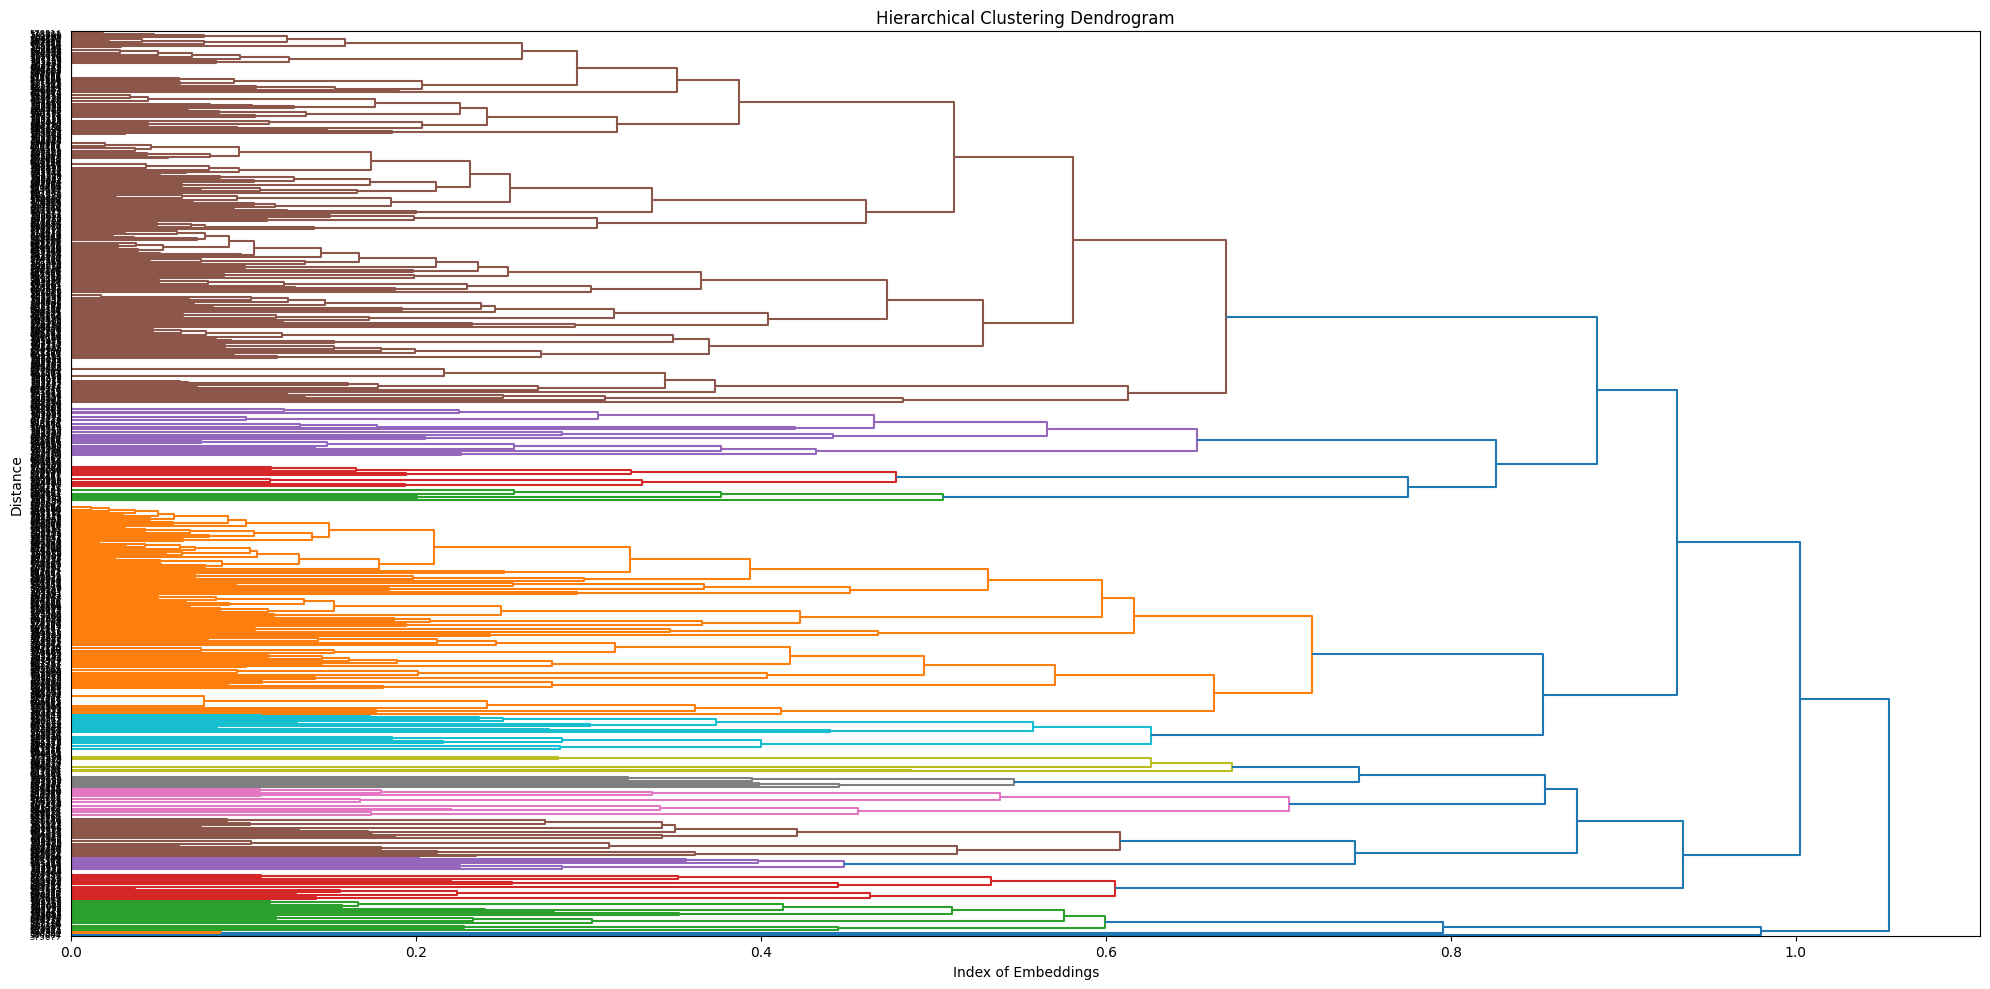

In [48]:
# Perform Hierarchical Clustering
Z = sch.linkage(
    embeddings_np,
    method='complete',
    metric='cosine',
    optimal_ordering=True) # set to false when large scale (slows down computation)

# Step 4: Plot the dendrogram to visualize the hierarchy tree
plt.figure(figsize=(20,10))
sch.dendrogram(Z,labels=skills_jobs_df['SP ID'].values,  leaf_rotation=0, count_sort=True, distance_sort=True, orientation='right', leaf_font_size=6)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Index of Embeddings")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig('participant-dendrogram.png', format='png', dpi=300)
# plt.show()

In [49]:
def cluster_hierarchy_tree(Z, skills_jobs_df, dist=0.5):
    cluster_labels = sch.fcluster(Z, t=dist, criterion='distance')
    clustered = defaultdict(list)
    for i, label in enumerate(cluster_labels):
        clustered[label].append(skills_jobs_df['Skills Jobs'].iloc[i])  # Group string names by cluster label
    return clustered

def print_cluster(clustered):
    for i in range(0, len(clustered)):
        print(f"Cluster {i}: {clustered[i]}")


dist_threshs = np.arange(.1, 1, .1)
histograms = dict()
for dist in dist_threshs:
    print(f"Clusters at distance threshold {dist}")
    clustered = cluster_hierarchy_tree(Z, skills_jobs_df, dist)
    print_cluster(clustered)
    histograms[dist] = [len(strings) for strings in clustered.values()]

Clusters at distance threshold 0.1
Cluster 0: []
Cluster 1: ['Construction & Fabrication / Drafting - AutoCad', 'Construction & Fabrication / Drafting - AutoCad Engineering / Mechanial Engineer', 'Construction & Fabrication / Drafting - AutoCad']
Cluster 2: ['Arts and Crafts / Fashion Designer', 'Arts and Crafts / Fashion Designer']
Cluster 3: ['Arts and Crafts / Digital Animator Arts and Crafts / Fashion Designer']
Cluster 4: ['Soft Skills / Enthusiastic Arts and Crafts / Graphic Designer', 'Soft Skills / Enthusiastic Arts and Crafts / Fashion Designer']
Cluster 5: ['Arts and Crafts / Dancer Medical / Dentist']
Cluster 6: ['Arts and Crafts / Film Director Arts and Crafts / Photographer', 'Arts and Crafts / Film Director Arts and Crafts / Painter Arts and Crafts / Photographer']
Cluster 7: ['Arts and Crafts / Film Cinematographer Arts and Crafts / Film Director Media and Communication / Script Writer Arts and Crafts / Video Editor']
Cluster 8: ['Arts and Crafts / Film Cinematographer',

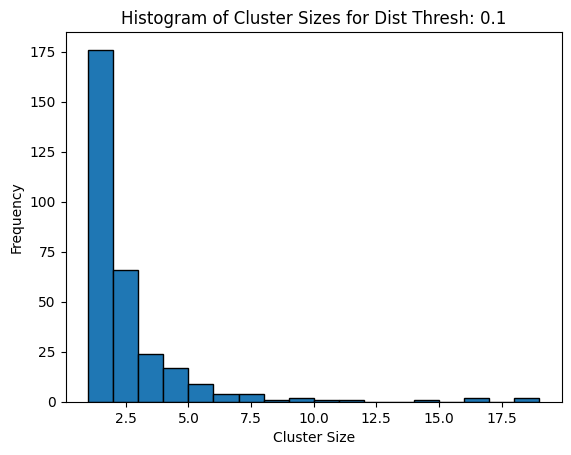

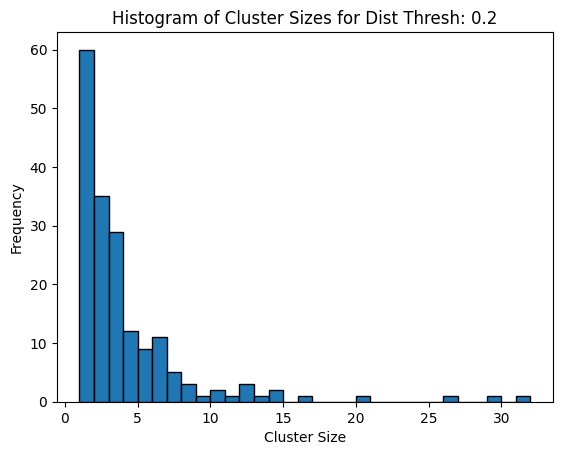

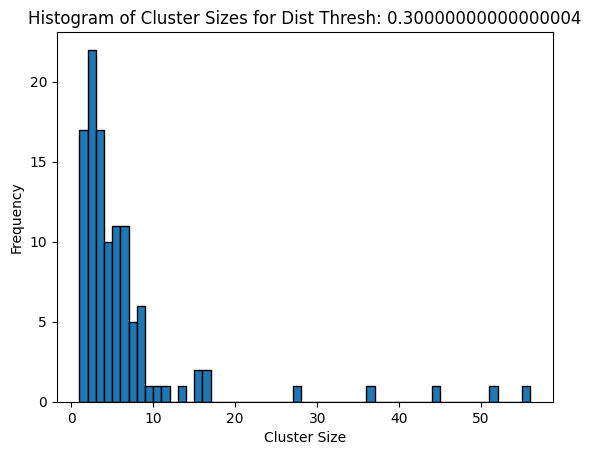

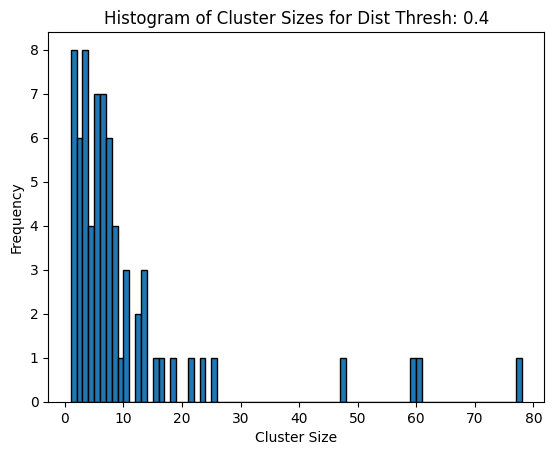

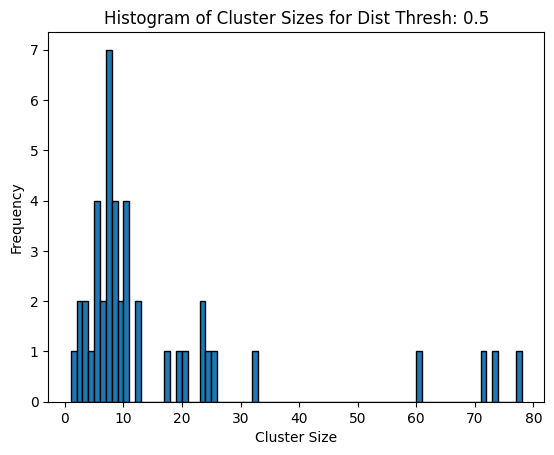

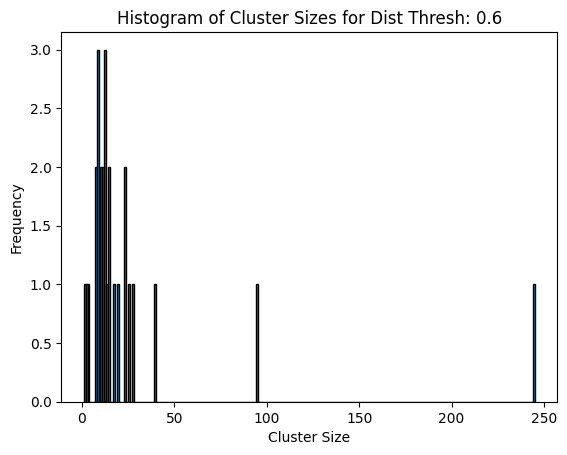

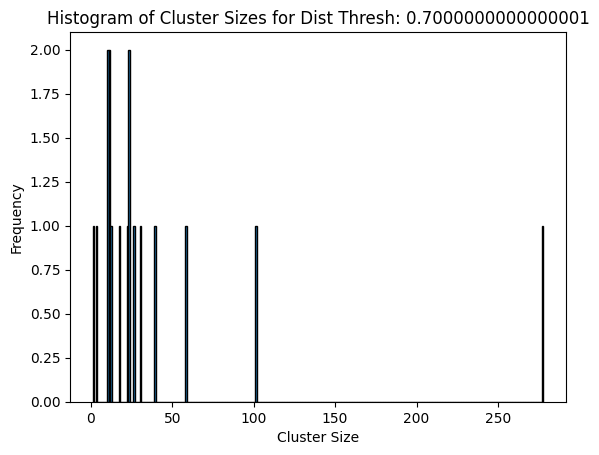

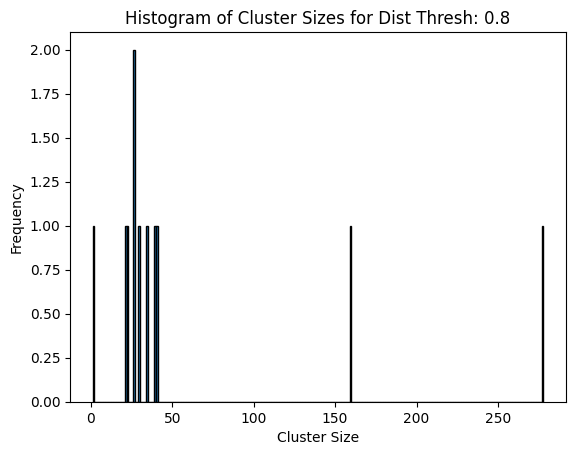

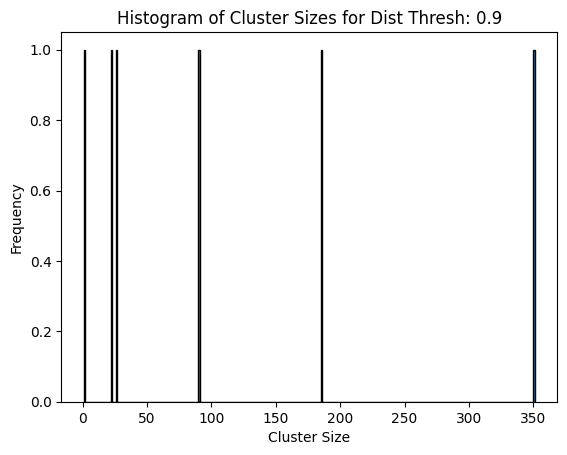

In [50]:
for i, (dist, histogram) in enumerate(histograms.items()):
    # Step 1: Get the size of each cluster
    # cluster_sizes = [len(strings) for strings in clusters.values()]
    
    # Step 2: Create the histogram
    plt.figure(i)  # Create a new figure for each plot
    plt.hist(histogram, bins=range(1, max(histogram)+2), edgecolor='black')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Cluster Sizes for Dist Thresh: {dist}')

# Show all plots at once (after the loop)
plt.show()
